<a href="https://colab.research.google.com/github/dannnshe/14-Deep-Learning/blob/main/14_Deep_Learning_LSTM_Stock_Predictor_Using_Fear_and_Greed_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
pip install hvplot

In [14]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [15]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [16]:
from google.colab import files
uploaded = files.upload()

Saving btc_historic.csv to btc_historic.csv


In [17]:
from google.colab import files
uploaded = files.upload()

Saving btc_sentiment.csv to btc_sentiment.csv


In [18]:
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [19]:
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [20]:
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [21]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [22]:
window_size= 10 
feature_column= 0 
target_column=1
X, y= window_data(df, window_size, feature_column, target_column)

print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[30 15 40 24 11  8 36 30 44 54]
 [15 40 24 11  8 36 30 44 54 31]
 [40 24 11  8 36 30 44 54 31 42]] 

y sample values:
[[8084.609863]
 [8911.269531]
 [8544.69043 ]]


In [23]:
split = int(0.7 * len(X))

X_train= X[:split]
X_test= X[split:]

y_train= y[:split]
y_test= y[split:]

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler()
scaler.fit(X)
X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

scaler.fit(y)
y_train=scaler.transform(y_train)
y_test=scaler.transform(y_test)

In [25]:
X_train= X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test= X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.25287356]
  [0.08045977]
  [0.36781609]
  [0.18390805]
  [0.03448276]
  [0.        ]
  [0.31395349]
  [0.24418605]
  [0.40697674]
  [0.52325581]]

 [[0.08045977]
  [0.36781609]
  [0.18390805]
  [0.03448276]
  [0.        ]
  [0.32183908]
  [0.24418605]
  [0.40697674]
  [0.52325581]
  [0.25581395]]

 [[0.36781609]
  [0.18390805]
  [0.03448276]
  [0.        ]
  [0.32183908]
  [0.25287356]
  [0.40697674]
  [0.52325581]
  [0.25581395]
  [0.38372093]]] 

X_test sample values:
[[[0.36781609]
  [0.43678161]
  [0.34482759]
  [0.45977011]
  [0.45977011]
  [0.40229885]
  [0.39534884]
  [0.37209302]
  [0.3372093 ]
  [0.62790698]]

 [[0.43678161]
  [0.34482759]
  [0.45977011]
  [0.45977011]
  [0.40229885]
  [0.40229885]
  [0.37209302]
  [0.3372093 ]
  [0.62790698]
  [0.65116279]]

 [[0.34482759]
  [0.45977011]
  [0.45977011]
  [0.40229885]
  [0.40229885]
  [0.37931034]
  [0.3372093 ]
  [0.62790698]
  [0.65116279]
  [0.58139535]]]


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [27]:
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer

model.add(Dense(1))

In [28]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [37]:
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=18, verbose=1)

Epoch 1/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0354
Epoch 2/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0336
Epoch 3/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0349
Epoch 4/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0342
Epoch 5/10
21/21 [==============================] - 0s 7ms/step - loss: 0.0349
Epoch 6/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0338
Epoch 7/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0354
Epoch 8/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0354
Epoch 9/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0372
Epoch 10/10
21/21 [==============================] - 0s 6ms/step - loss: 0.0340


In [38]:
model.evaluate(X_test, y_test, verbose=0)

0.1015697717666626

In [39]:
predicted=model.predict(X_test)

In [42]:
predicted_prices= scaler.inverse_transform(predicted)
real_prices= scaler.inverse_transform(y_test.reshape(-1,1))

In [48]:
df = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 

df.head()

,Actual,Predicted
2019-02-20,3924.239990,7376.360352
2019-02-21,3974.050049,7566.069824
2019-02-22,3937.040039,7775.485840
2019-02-23,3983.530029,8046.839844
2019-02-24,4149.089844,8265.118164


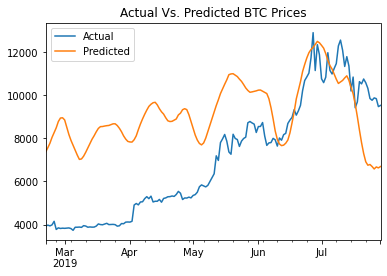

In [46]:
df.plot(title="Actual Vs. Predicted BTC Prices")